# Fix jumps with organized data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from tqdm import tqdm
from utils.fix_jumps_utils import * 
from utils.transform_utils import *
from utils.basic_utils import joint_density_function
import scipy.interpolate as interpolate
from glob import glob
from utils.class_utils import SessionData

In [2]:
def plot_height(this_begin,this_end, markers, fix_markers,coor = 1):
    fig, axes = plt.subplots(2,1,figsize = (10,7))
    axes = axes.flatten()
    features = ['before','after']
    x = np.arange(this_begin, this_end)
    coor_features = ['x','height','z']
    for i, marker in enumerate([markers, fix_markers]):
        axes[i].plot(x,marker[this_begin:this_end,0,coor],label = 'marker %d'%1)
        axes[i].plot(x,marker[this_begin:this_end,1,coor],label = 'marker %d'%2)
        axes[i].plot(x,marker[this_begin:this_end,2,coor],label = 'marker %d'%3)
        axes[i].plot(x, marker[this_begin:this_end,3,coor],label = 'marker %d'%4)
        axes[i].legend()
        axes[i].set_title('%s of marker %s fix of jumps'%(coor_features[coor],features[i]))
    plt.show()
    return fig

# 1. Prepare the data

In [3]:
# # file_path = '../Data/Raw/FS11_20220322-185620/FS11_20220322-185620_actual.csv'
# file_path = '../Data/Raw/Take 2022-04-10 02.04.09 PM.csv'
# file_path = '../Data/Raw/Take 2022-04-10 04.05.33 PM.csv'
# raw_data = pd.read_csv(file_path, skiprows=[0],index_col=None, header= [1,2,3,4])

# find the angle between planar and markers
marker2 = (np.array([-11.5940055847168,76.7821273803711,32.8862037658691]).astype(np.double) + np.array([-20.0353107452393,76.1766967773438,33.3508110046387]).astype(np.double))/2
marker4 = (np.array([-22.9617519378662,65.8352813720703,35.0914268493652]).astype(np.double)+np.array([-22.1987762451172,57.3939704895020,35.1079902648926]).astype(np.double))/2
marker1 = (np.array([-41.6435813903809,55.2603759765625,34.3363189697266]).astype(np.double)+np.array([-42.1081886291504,63.7016830444336,33.7308883666992]).astype(np.double))/2
marker3 = (np.array([-5.23669624328613,48.4213142395020,36.6272659301758]).astype(np.double)+np.array([-5.58885765075684,56.8760604858398,37.1082000732422]).astype(np.double))/2
stl_markers = np.array([marker1,marker2,marker3,marker4])
stl_markers = stl_markers[:,[1,2,0]] # put z to y place, and y to z place 

# for the planar
marker5 = np.array([-10.3863134384155,69.2393875122070,30.1468048095703]).astype(np.double)
marker6 = np.array([-33.4978103637695,52.8659744262695,30.1468048095703]).astype(np.double)
marker7 = np.array([-33.4978103637695,69.2393875122070,30.1468048095703]).astype(np.double)
planar_marker = np.array([marker5,marker6, marker7])
planar_marker = planar_marker[:,[1,2,0]]

In [8]:
root_path = './data/raw_data/'
rat_id = 'FS11'
rat_subdirectories = glob(root_path+rat_id+'/*.csv' )
print(rat_subdirectories)

['./data/raw_data/FS11/Take 2022-03-11 04.16.35 PM.csv', './data/raw_data/FS11/Take 2022-03-22 06.56.20 PM.csv', './data/raw_data/FS11/Take 2022-03-16 03.14.17 PM.csv', './data/raw_data/FS11/Take 2022-04-11 04.56.22 PM.csv', './data/raw_data/FS11/Take 2022-03-18 01.07.16 PM.csv', './data/raw_data/FS11/Take 2022-03-30 01.48.15 PM.csv']


# 2. Initiate the class structure

## 2.1 initiate, get the basic structure

In [5]:
which_session = 0
this_session = SessionData(rat_subdirectories[which_session], stl_markers)
this_session.init()

In [6]:
jump_slice= this_session.fix_flip(differential_thresh=0.005, basic_neighbor=5, distance_neigobor=80, which_method = 'distance') # fix the filp of markers
this_session.recheck_filp()

15604it [00:02, 7533.95it/s]
2542it [00:00, 7430.77it/s]


In [ ]:
for i in range(1,len(rat_subdirectories)):
    which_method = 'distance'
    this_session = SessionData(rat_subdirectories[i], stl_markers)
    date = rat_subdirectories[i].split('/')[-1].split(' ')[1]
    print(date)
    this_session.init()
    jump_slice= this_session.fix_flip(differential_thresh=0.005, basic_neighbor=5, distance_neigobor=80, which_method = which_method) # fix the filp of markers
    # fix the filp of markers
    this_session.recheck_filp()
    this_session.interpolate_missing_data(gap_thresh=5, neighbors=2)
    this_session.generate_more_features(feature='interpolated_markers')
    this_session.generate_neckposition()
    # # Save
    dictionary = {'flip_idx':this_session.re_flip_index, 'non_interpolated_markers':this_session.recheck_markers,'markers':this_session.interpolated_markers,'angles':this_session.interpolated_angles,'speed1d':this_session.speed_1d, 'speed2d':this_session.speed_2d,'speed3d':this_session.speed_3d,'neck':this_session.neckpostion, 'raw_markers':this_session.markers}
    np.save('./data/processed_data/%s/%s/%s.npy'%(rat_id,which_method, date), dictionary) 

    
    ## plot the results
    [fir_range1, sec_range1], joint_pro1 = joint_density_function(this_session.recheck_markers[:,-1,1], this_session.re_fix_angles[:,-1],steps=[0.001,1],set_max=True,max_x=[0.8,180], set_min=True, min_x=[0.4,-180])
    [fir_range2, sec_range2], joint_pro2 = joint_density_function(this_session.markers[:,-1,1], this_session.raw_angles[:,-1],steps=[0.001,1],set_max=True,max_x=[0.8,180], set_min=True, min_x=[0.4,-180])
    fig, axis = plt.subplots(1,2, figsize = (14,7))
    axis = axis.flatten()
    heatmap1 = axis[0].imshow(np.flip(np.log(joint_pro1),axis=0), cmap = 'rainbow', interpolation='none', aspect='auto', extent=[fir_range1[0],fir_range1[-1],sec_range1[0],sec_range1[-1]])
    axis[0].set_xlabel('height')
    axis[0].set_ylabel('pitch')
    fig.colorbar(heatmap1,)
    axis[0].set_title('JPD flipped data')
    heatmap2 = axis[1].imshow(np.flip(np.log(joint_pro2),axis=0), cmap = 'rainbow', interpolation='none', aspect='auto', extent=[fir_range2[0],fir_range2[-1],sec_range2[0],sec_range2[-1]])
    axis[1].set_xlabel('height')
    axis[1].set_ylabel('pitch')
    fig.colorbar(heatmap2,)
    axis[1].set_title('JPD raw data')

In [ ]:
this_session.re_flip_index

In [ ]:
this_session.interpolate_missing_data()
# this_session.generate_more_features(feature='fix_markers')

# 3. Plot the resutls

/var/folders/rm/m418549n60ldjvfgbchrnp8r0000gn/T/ipykernel_25772/967747663.py:5: RuntimeWarning: divide by zero encountered in log
  heatmap1 = axis[0].imshow(np.flip(np.log(joint_pro1),axis=0), cmap = 'rainbow', interpolation='none', aspect='auto', extent=[fir_range1[0],fir_range1[-1],sec_range1[0],sec_range1[-1]])
/var/folders/rm/m418549n60ldjvfgbchrnp8r0000gn/T/ipykernel_25772/967747663.py:10: RuntimeWarning: divide by zero encountered in log
  heatmap2 = axis[1].imshow(np.flip(np.log(joint_pro2),axis=0), cmap = 'rainbow', interpolation='none', aspect='auto', extent=[fir_range2[0],fir_range2[-1],sec_range2[0],sec_range2[-1]])


Text(0.5, 1.0, 'JPD raw data')

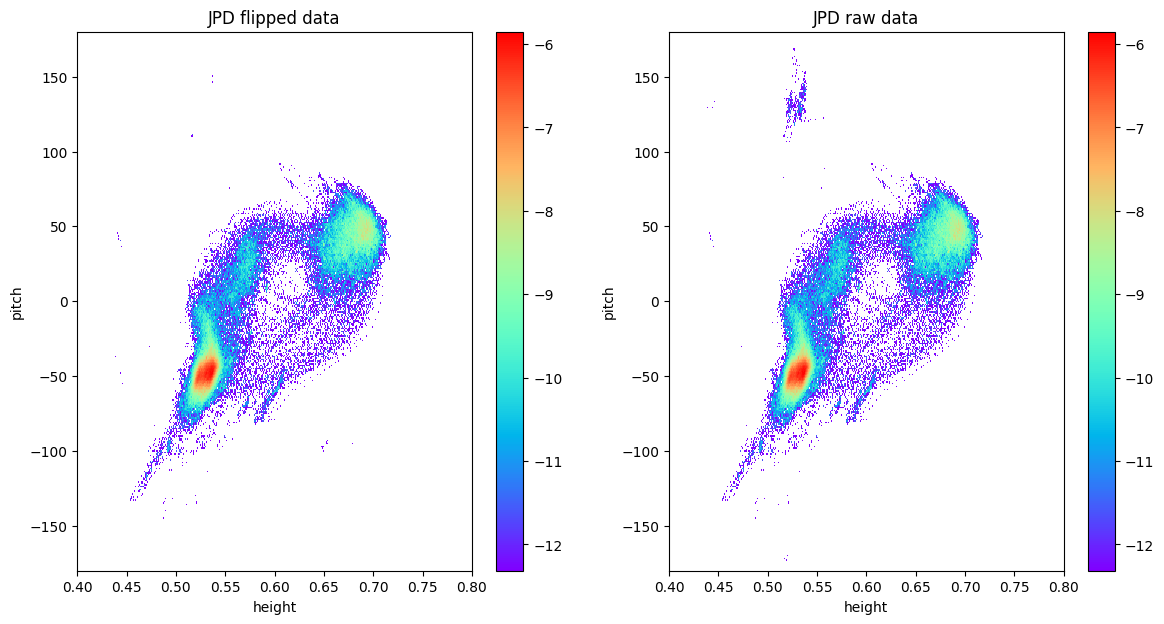

In [317]:
[fir_range1, sec_range1], joint_pro1 = joint_density_function(this_session.recheck_markers[:,-1,1], this_session.re_fix_angles[:,-1],steps=[0.001,1],set_max=True,max_x=[0.8,180], set_min=True, min_x=[0.4,-180])
[fir_range2, sec_range2], joint_pro2 = joint_density_function(this_session.markers[:,-1,1], this_session.raw_angles[:,-1],steps=[0.001,1],set_max=True,max_x=[0.8,180], set_min=True, min_x=[0.4,-180])
fig, axis = plt.subplots(1,2, figsize = (14,7))
axis = axis.flatten()
heatmap1 = axis[0].imshow(np.flip(np.log(joint_pro1),axis=0), cmap = 'rainbow', interpolation='none', aspect='auto', extent=[fir_range1[0],fir_range1[-1],sec_range1[0],sec_range1[-1]])
axis[0].set_xlabel('height')
axis[0].set_ylabel('pitch')
fig.colorbar(heatmap1,)
axis[0].set_title('JPD flipped data')
heatmap2 = axis[1].imshow(np.flip(np.log(joint_pro2),axis=0), cmap = 'rainbow', interpolation='none', aspect='auto', extent=[fir_range2[0],fir_range2[-1],sec_range2[0],sec_range2[-1]])
axis[1].set_xlabel('height')
axis[1].set_ylabel('pitch')
fig.colorbar(heatmap2,)
axis[1].set_title('JPD raw data')

# 4. Debug 

In [208]:
ab_idx = np.argwhere((this_session.fix_angles[:,-1] >100)| (this_session.re_fix_angles[:,-1] <-100)).reshape(-1)
print(ab_idx.shape)

(258,)


In [206]:
raw_idx =  np.argwhere((this_session.raw_angles[:,-1]>100)| (this_session.raw_angles[:,-1] <-100)).reshape(-1)
print(raw_idx.shape)

(712,)


In [202]:
all_ = np.setdiff1d(ab_idx, raw_idx)

In [12]:
marker_quality = marker_quality[this_session.non_nan_idx]

In [197]:
a,b = continuous_detection(all_,seperate=True)

In [198]:
all_len =[]
for a in b:
    all_len.append(a.shape[0])

In [199]:
all_idx = np.argsort(all_len)

In [200]:
all_idx

array([22, 19, 18, 17, 16, 14, 27, 24, 31, 40, 21,  8, 36,  6, 37, 23,  9,
        5, 15,  4, 38, 25,  0, 39, 33, 30, 20,  3,  2, 26, 41, 28, 12, 13,
       32, 34,  1, 10,  7, 11, 35, 29])

In [201]:
idx = 29
print(b[idx])
print(len(b[idx]))

[134752 134753 134754 134755 134756 134757 134758 134759 134760 134761
 134762 134763 134764 134765 134766 134767 134768 134769 134770 134771
 134772 134773 134774 134775 134776 134777 134778 134779 134780 134781
 134782 134783 134784 134785 134786 134787 134788 134789 134790 134791
 134792 134793 134794 134795 134796 134797 134798 134799 134800 134801
 134802 134803 134804 134805 134806 134807 134808 134809 134810 134812
 134813 134814 134815 134816 134817 134818 134819 134820 134821 134822
 134823 134824 134825 134826 134827 134828 134829 134830 134831]
79


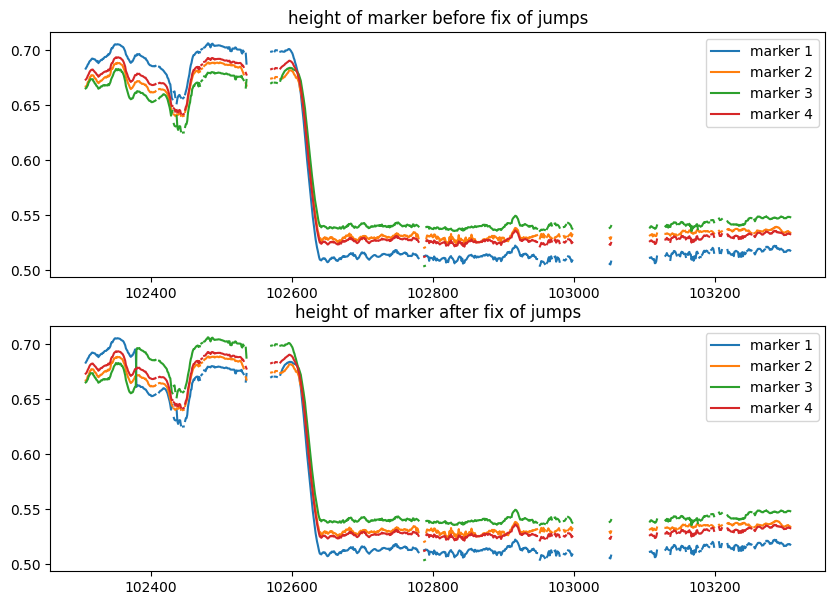

In [279]:

delta_diff = np.diff(this_session.markers[:,0,1]) - np.diff(this_session.markers[:,2,1]) # marker1 and marker3, difference of the first order differential 
# plt.plot(np.arange(begin, end-1,1),np.abs(delta_diff))
begin = 102608-300
end = begin +1000
fig = plot_height(begin, end, this_session.markers, this_session.fix_markers)

In [281]:
discontinu_tolerance = 10
neigobor = 50
differential_thresh = 0.02
inferred_range= 100
non_idx = np.argwhere(~np.isnan(this_session.markers[begin:end,0,0])).reshape(-1)
nan_idx = np.argwhere(np.isnan(this_session.markers[begin:end,0,0])).reshape(-1)
clean_markers = this_session.markers[begin:end][non_idx]
jump_slice = detect_jumps(clean_markers,delta_threshold=0.02, single_threshold=0.005,)        
# smooth_loc,transition_direction = detect_transition(clean_markers,diff_thresh=differential_thresh,discontinu_tolerance = discontinu_tolerance, neighbor=neigobor)
smooth_loc = [0]
# # get the fixed version of markers (corresponded to markers)
# fix_markers = fix_jumps_with_transition_state(clean_markers, jump_slice, smooth_loc= smooth_loc, transition_direction = transition_direction, neighbor=2)    

# # do another kind of flip decection
# sec_jump_slice = detect_jumps(fix_markers,delta_threshold=differential_thresh, single_threshold=0.005)          
# rough_fixmarkers = fix_jumps(fix_markers, sec_jump_slice, neighbor= neigobor)
# fix_markers = fix_jumps_with_pitch(clean_markers, jump_slice,self.raw_angles[:,-1], tolerance= tolerance)    
fix_markers= detect_jumps_with_distance(clean_markers, jump_slice, marker_quality, smooth_loc, neighbor= neigobor,inferred_range=inferred_range)

fix = np.copy(this_session.markers[begin:end,:,:])
fix[non_idx,:,:] = fix_markers

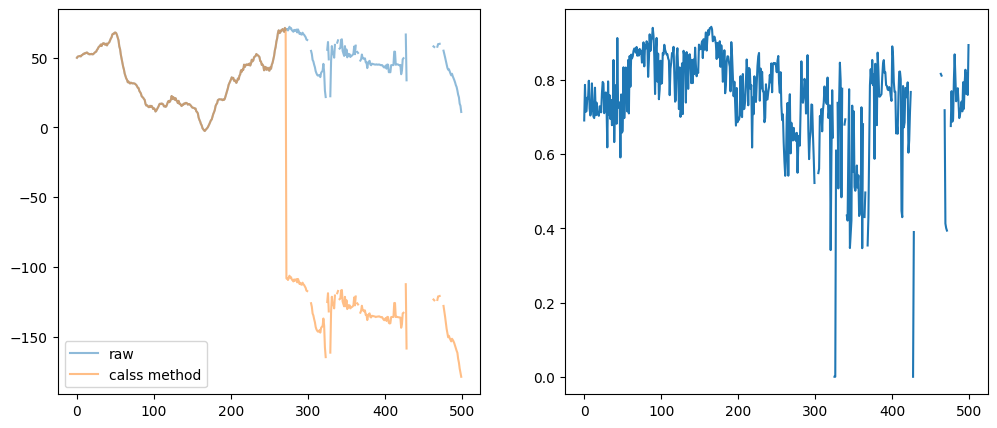

In [210]:
fig, axis = plt.subplots(1,2,figsize = (12,5))
axis[0].plot(this_session.raw_angles[begin:end,-1],label = 'raw',alpha = 0.5)
# axis[0].plot(this_angle[begin:end,-1],label = 'fixed',alpha = 0.5)
axis[0].plot(this_session.fix_angles[begin:end, -1],label = 'calss method',alpha = 0.5)
axis[0].legend()
axis[1].plot(marker_quality[begin:end,0],label = 'raw')
axis[0].scatter(flipped, np.zeros_like(flipped),s = 1)

In [170]:
def calculate_average_sliding_window(x,window = 10):
    former_sum = np.cumsum(x[0:-window])
    latter_sum = np.cumsum(x[window:])+ former_sum[window-1]
    return (latter_sum - former_sum)/window

#